In [10]:
import os
from glob import glob

from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.applications.vgg16 import VGG16 as VGG
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (Conv2D, Dense, GlobalAveragePooling2D,
                                     Input)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

from image_functions import simple_image_generator

In [11]:
# variables
path_to_split_datasets = "H:\Multi-Spectral-Satelite-Image-Classification\Dataset\ProcessedData10bands"
use_vgg = True
batch_size = 64

class_indices = {'building': 0, 'farmland': 1, 'vegetation': 2}
num_classes = len(class_indices)

In [12]:
# contruct path
path_to_home = os.path.expanduser("~")
path_to_split_datasets = path_to_split_datasets.replace("~", path_to_home)
path_to_train = os.path.join(path_to_split_datasets, "train")
path_to_validation = os.path.join(path_to_split_datasets, "validation")

In [13]:
# parameters for CNN
input_tensor = Input(shape=(64, 64, 10))
# introduce a additional layer to get from 13 to 3 input channels
input_tensor = Conv2D(3, (1, 1))(input_tensor)
if use_vgg:
    base_model_imagenet = VGG(include_top=False,
                              weights='imagenet',
                              input_shape=(64, 64, 3))
    base_model = VGG(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)
    for i, layer in enumerate(base_model_imagenet.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())
else:
    base_model_imagenet = DenseNet(include_top=False,
                                   weights='imagenet',
                                   input_shape=(64, 64, 3))
    base_model = DenseNet(include_top=False,
                          weights=None,
                          input_tensor=input_tensor)
    for i, layer in enumerate(base_model_imagenet.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

# add a global spatial average pooling layer
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
# or just flatten the layers
# top_model = Flatten()(top_model)

In [14]:
# let's add a fully-connected layer
if use_vgg:
    # only in VGG19 a fully connected nn is added for classfication
    # DenseNet tends to overfitting if using additionally dense layers
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
# and a logistic layer
predictions = Dense(num_classes, activation='softmax')(top_model)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# print network structure
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 10)]      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         33        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)      

In [15]:
# defining ImageDataGenerators
# ... initialization for training
training_files = glob(path_to_train + "/**/*.tif")
train_generator = simple_image_generator(training_files, class_indices,
                                         batch_size=batch_size,
                                         rotation_range=45,
                                         horizontal_flip=True,
                                         vertical_flip=True)

# ... initialization for validation
validation_files = glob(path_to_validation + "/**/*.tif")
validation_generator = simple_image_generator(validation_files, class_indices,
                                              batch_size=batch_size)

In [16]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False
# set convolution block for reducing 13 to 3 layers trainable
for layer in model.layers[:2]:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [17]:
# generate callback to save best model w.r.t val_categorical_accuracy
if use_vgg:
    file_name = "vgg"
else:
    file_name = "dense"
checkpointer = ModelCheckpoint("H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\10_band_Models\\" + file_name +
                               "_ms_transfer_first." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}." +
                               "hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=50,
                             mode='max',
                             restore_best_weights=True)

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=12,
    epochs=12,
    callbacks=[checkpointer, earlystopper],
    validation_data=validation_generator,
    validation_steps=1)
initial_epoch = len(history.history['loss']) + 1

Epoch 1/12
12/12 [==============================] - ETA: 0s - loss: 4.8028 - categorical_accuracy: 0.3451
Epoch 00001: val_categorical_accuracy improved from -inf to 0.42188, saving model to H:\Multi-Spectral-Satelite-Image-Classification\Temp_Model_band_Models\vgg_ms_transfer_first.01-0.422.hdf5
12/12 [==============================] - 34s 3s/step - loss: 4.8028 - categorical_accuracy: 0.3451 - val_loss: 1.1677 - val_categorical_accuracy: 0.4219
Epoch 2/12
12/12 [==============================] - ETA: 0s - loss: 1.4105 - categorical_accuracy: 0.3815
Epoch 00002: val_categorical_accuracy improved from 0.42188 to 0.51562, saving model to H:\Multi-Spectral-Satelite-Image-Classification\Temp_Model_band_Models\vgg_ms_transfer_first.02-0.516.hdf5
12/12 [==============================] - 33s 3s/step - loss: 1.4105 - categorical_accuracy: 0.3815 - val_loss: 1.2066 - val_categorical_accuracy: 0.5156
Epoch 3/12
12/12 [==============================] - ETA: 0s - loss: 1.2600 - categorical_accura

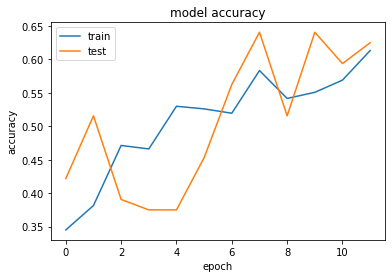

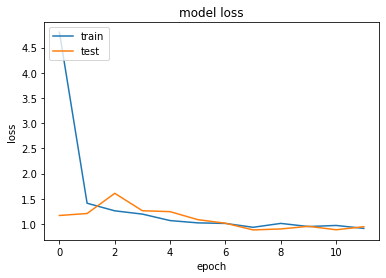

In [19]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
names = []
for i, layer in enumerate(model.layers):
    names.append([i, layer.name, layer.trainable])
print(names)

if use_vgg:
    # we will freaze the first convolutional block and train all
    # remaining blocks, including top layers.
    for layer in model.layers[:2]:
        layer.trainable = True
    for layer in model.layers[2:5]:
        layer.trainable = False
    for layer in model.layers[5:]:
        layer.trainable = True
else:
    for layer in model.layers[:2]:
        layer.trainable = True
    for layer in model.layers[2:8]:
        layer.trainable = False
    for layer in model.layers[8:]:
        layer.trainable = True

[[0, 'input_3', True], [1, 'conv2d_1', True], [2, 'block1_conv1', False], [3, 'block1_conv2', False], [4, 'block1_pool', False], [5, 'block2_conv1', True], [6, 'block2_conv2', True], [7, 'block2_pool', True], [8, 'block3_conv1', True], [9, 'block3_conv2', True], [10, 'block3_conv3', True], [11, 'block3_pool', True], [12, 'block4_conv1', True], [13, 'block4_conv2', True], [14, 'block4_conv3', True], [15, 'block4_pool', True], [16, 'block5_conv1', True], [17, 'block5_conv2', True], [18, 'block5_conv3', True], [19, 'block5_pool', True], [20, 'global_average_pooling2d_1', True], [21, 'dense_3', True], [22, 'dense_4', True], [23, 'dense_5', True]]


In [22]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [23]:
# generate callback to save best model w.r.t val_categorical_accuracy
if use_vgg:
    file_name = "vgg"
else:
    file_name = "dense"
checkpointer = ModelCheckpoint("H:\Multi-Spectral-Satelite-Image-Classification\Temp_Models\\10_band_Models\\" + file_name +
                               "_ms_transfer_final." +
                               "{epoch:02d}-{val_categorical_accuracy:.3f}." +
                               "hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               save_best_only=True,
                               mode='max')
earlystopper = EarlyStopping(monitor='val_categorical_accuracy',
                             patience=50,
                             mode='max',
                             restore_best_weights=True)

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=1000,
    epochs=10000,
    callbacks=[checkpointer, earlystopper],
    validation_data=validation_generator,
    validation_steps=500,
    initial_epoch=initial_epoch)

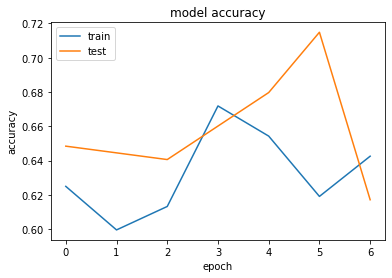

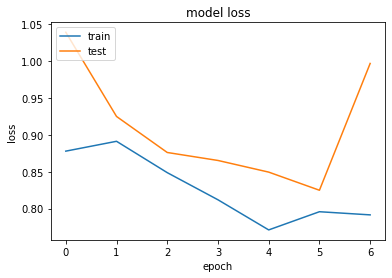

In [19]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()